In [3]:
import os
os.environ['OPENBLAS_NUM_THREADS'] = '1'

%matplotlib inline

import csv
import re
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import warnings
from csv_reader import read_csv
from aux import set_smallest_n_zero
from disp import set_font_size
from copy import deepcopy as copy
from analysis_tools import *
from pathlib import Path

new_rc_params = {
    'text.usetex': False,
    "svg.fonttype": 'none'
}
matplotlib.rcParams.update(new_rc_params)

plt.rcParams['font.size'] = 15
plt.rcParams['axes.linewidth'] = 3.0

warnings.filterwarnings('ignore')

rule_names = [ # Define labels for all rules to be run during simulations
    r'Const',
    r'$y$',
    r'$x$',
    r'$x \, y$',
    r'$y_{int}$',
    r'$x \, y_{int}$',
    r'$x_{int}$',
    r'$x_{int} \, y$',
    r'$y_{int} \, y$',
    r'$x_{int} \, x$',

    r'$w$',
    r'$w \, y$',
    r'$w \, x$',
    r'$w \, x \, y$',
    r'$w y_{int}$',
    r'$w x \, y_{int}$',
    r'$w x_{int}$',
    r'$w x_{int} \, y$',
    r'$w y_{int} \, y$',
    r'$w x_{int} \, x$',
]

time_constants = [
    r'$\tau \, y_{int}$',
    r'$\tau \, x \, y_{int}$',
    r'$\tau \, x_{int}$',
    r'$\tau \, x_{int} \, y$',
    r'$\tau \, y_{int} \, y$',
    r'$\tau \, x_{int} \, x$',
    
    r'$\tau \, w y_{int}$',
    r'$\tau \, w x \, y_{int}$',
    r'$\tau \, w x_{int}$',
    r'$\tau \, w x_{int} \, y$',
    r'$\tau \, w y_{int} \, y$',
    r'$\tau \, w x_{int} \, x$',
]

general_rule_names = copy(rule_names)

rule_names = [
    [r'$E \rightarrow E$ ' + r_name for r_name in rule_names],
    [r'$E \rightarrow I$ ' + r_name for r_name in rule_names],
    [r'$I \rightarrow E$ ' + r_name for r_name in rule_names],
]
rule_names = np.array(rule_names).flatten()

In [4]:
def plot_opt_run(file_name, n_plasticity_coefs, n_time_constants, batch_size, start=0, yscale=None, n_categories=1, loss_yscale=None):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    test_data_path = f'./sims_out/{file_name}/test_data.csv'
    
    df_train = read_csv(train_data_path, read_header=False)
    df_test = read_csv(test_data_path, read_header=False)
    
    # plot synaptic effects per rule
    scale = 2
    fig, axs = plt.subplots(1, 2, figsize=(6 * scale, 2.5 * scale))
    format_axs(axs)
    
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Rule coefficient')
    if yscale is not None:
        axs[0].set_ylim(0, yscale)
    
    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    x = np.arange(df_train.shape[0])[start:]
    losses = df_train[df_train.columns[1]][start:]
    x_mins = []

    for i in range(0, len(x), 15):
        x_mins.append(np.argmin(losses[i:i+15]) + i)
        
    x_mins = np.array(x_mins)
    x_best_min = np.argmin(losses)
    
    x_test = df_test[df_test.columns[0]]
    losses_test = df_test[df_test.columns[1]]
    
    final_syn_effects = []
    final_coefs = []
    
    for i in range(syn_effect_start, syn_effect_end):
#         axs[0].plot(df_train[df_train.columns[0]][start:][x_mins], df_train[df_train.columns[i]][start:][x_mins])
        
        final_syn_effects.append(df_train[df_train.columns[i]][start:][x_best_min])
        
    final_syn_effects = np.array(final_syn_effects)
        
    axs[1].plot(x_mins[1:-1], losses[x_mins[1:-1]], color='black')
    axs[1].plot(x_test, losses_test, color='blue')
    axs[1].set_ylim(0, 3000)
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epochs')
        
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants
    
    for i in range(plasticity_coefs_start, plasticity_coefs_end):
        axs[0].plot(df_train[df_train.columns[0]][start:][x_mins], df_train[df_train.columns[i]][start:][x_mins])
        final_coefs.append(df_train[df_train.columns[i]][start:][x_best_min])
        
    set_font_size(axs[0], 20)
    set_font_size(axs[1], 20)
    fig.tight_layout()
    fig.savefig(os.path.join(figure_path, 'loss_and_coef_evo.png'))
    fig.savefig(os.path.join(figure_path, 'loss_and_coef_evo.svg'))
    
    final_coefs = np.array(final_coefs)
    
    # plot the synaptic effects of each plasticity rule (unsorted by size)
    scale = 2
    fig, axs = plt.subplots(n_categories, 1, figsize=(6 * scale, 3 * n_categories * scale))
    if n_categories == 1:
        axs = [axs]
    
    partial_rules_len = int(len(final_syn_effects) / n_categories)

    for l in range(n_categories):
        format_axs(axs[l])
        x = np.arange(partial_rules_len)
        y = final_syn_effects[l * partial_rules_len: (l+1) * partial_rules_len]
        colors = np.where(final_coefs[l * partial_rules_len: (l+1) * partial_rules_len] > 0, 'green', 'red')
#         y_err = final_syn_effect_stds[l * partial_rules_len: (l+1) * partial_rules_len]
        axs[l].bar(x, y, color=colors, alpha=0.3)
        axs[l].set_xticks(np.arange(partial_rules_len))
        axs[l].set_xticklabels(rule_names[l * partial_rules_len: (l+1) * partial_rules_len], rotation=60, ha='right')
        axs[l].set_ylabel('Absolute synaptic change')
        axs[l].set_xlim(-1, partial_rules_len)    
    
        set_font_size(axs[l], 20)
        

    fig.tight_layout()
    fig.savefig(os.path.join(figure_path, 'final_syn_change.png'))
    fig.savefig(os.path.join(figure_path, 'final_syn_change.svg'))
    
    # plot entropy of synaptic change per rule against epochs
    scale = 2
    fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
    format_axs(axs)
    
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Entropy')
    
    entropy = []
    for i in x_mins[1:]:
        syn_effects_i = np.array(df_train.iloc[i][syn_effect_start:syn_effect_end])
        entropy.append(calc_entropy(syn_effects_i))
        
    entropy = np.array(entropy)
    
    axs.plot(x_mins[1:], entropy, c='green')

    return np.array(final_syn_effects), np.array(final_coefs), losses[x_best_min]

In [5]:
def plot_all_opt_runs(all_files, n_plasticity_coefs, n_time_constants, batch_size, n_categories=3, l_thresh=1000, name='default'):
    figure_path = f'./figures/{name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    
    final_syn_effects = []
    final_plasticity_coefs = []

    for f in all_files:
        syn_effects_for_f, plasticity_coefs_for_f, best_loss_for_f = plot_opt_run(f, n_plasticity_coefs, n_time_constants, batch_size, n_categories=n_categories)
        if best_loss_for_f < l_thresh:
            print(f'{f}')
            final_syn_effects.append(syn_effects_for_f)
            final_plasticity_coefs.append(plasticity_coefs_for_f)

    final_syn_effects = np.stack(final_syn_effects)
    final_syn_effect_means = np.mean(final_syn_effects, axis=0)
    final_syn_effect_stds = np.std(final_syn_effects, axis=0) / np.sqrt(final_syn_effects.shape[0])

    final_plasticity_coefs = np.stack(final_plasticity_coefs)
    final_plasticity_coef_means = np.mean(final_plasticity_coefs, axis=0)
    final_plasticity_coef_stds = np.std(final_plasticity_coefs, axis=0) / np.sqrt(final_plasticity_coefs.shape[0])

    print(final_plasticity_coef_means)

    # plot the synaptic effects of each plasticity rule (unsorted by size)
    scale = 2
    fig, axs = plt.subplots(n_categories, 1, figsize=(6 * scale, 3 * n_categories * scale))
    if n_categories == 1:
        axs = [axs]
    partial_rules_len = int(len(final_syn_effect_means) / n_categories)

    for l in range(n_categories):
        format_axs(axs[l])
        x = np.arange(partial_rules_len)
        y = final_syn_effect_means[l * partial_rules_len: (l+1) * partial_rules_len]
        y_err = final_syn_effect_stds[l * partial_rules_len: (l+1) * partial_rules_len]
        colors = np.where(final_plasticity_coef_means[l * partial_rules_len: (l+1) * partial_rules_len] > 0, 'green', 'red')
        axs[l].bar(x, y, alpha=0.3, color=colors)
        axs[l].errorbar(x, y, yerr=y_err, ls='none', color='black')

        axs[l].set_xticks(np.arange(partial_rules_len))
        axs[l].set_xticklabels(rule_names[l * partial_rules_len: (l+1) * partial_rules_len], rotation=60, ha='right')
        axs[l].set_ylabel('Absolute synaptic change')
        axs[l].set_xlim(-1, partial_rules_len)
        
        set_font_size(axs[l], 20)

    fig.tight_layout()
    fig.savefig(os.path.join(figure_path, 'final_syn_change.png'))
    fig.savefig(os.path.join(figure_path, 'final_syn_change.svg'))

    # plot the synaptic effects of each plasticity rule as scatter plot
    scale = 2
    fig, axs = plt.subplots(3, 1, figsize=(6 * scale, 5.5 * scale))

    cmap = matplotlib.cm.get_cmap('nipy_spectral')
    colors = [cmap(x) for x in np.linspace(0, 0.55, final_syn_effects.shape[1])]
    np.random.shuffle(colors)

    max_val = 0
    for i in range(n_categories):
        for j in range(partial_rules_len):
            x = i * partial_rules_len + j
            y = final_syn_effects[:, x]
            axs[i].scatter(j * np.ones(final_syn_effects.shape[0]) + np.random.normal(0, 0.15, final_syn_effects.shape[0]), y, s=30, facecolors='none', edgecolors=colors[j], marker='o')

            if np.max(y) > max_val:
                max_val = np.max(y)
        axs[i].set_xlim(-1, partial_rules_len)
        if i < n_categories - 1:
            axs[i].set_xticks([])

    axs[2].set_xticklabels(general_rule_names, rotation=60)
    axs[2].set_xticks(np.arange(partial_rules_len))

    axs[1].set_ylabel('Absolute synaptic change')

    for i in range(n_categories):
        axs[i].set_ylim(0, max_val * 1.1)

    # plot covariance of synaptic changes due to each rule
    normed_syn_effect_means = final_syn_effect_means / np.sum(final_syn_effect_means)

    fig, axs = plt.subplots(1, 1, figsize=(4 * scale, 4 * scale))
    format_axs(axs)
    syn_effect_cov_mat = np.cov(np.array(final_syn_effects).T)
    max_abs_val = np.max(np.abs(syn_effect_cov_mat))
    mappable = axs.matshow(syn_effect_cov_mat, cmap='bwr', vmin=-max_abs_val, vmax=max_abs_val)
    plt.colorbar(mappable)
    axs.set_xticks(np.arange(len(final_syn_effect_means)))
    axs.set_xticklabels(rule_names[:len(final_syn_effect_means)], rotation=60)
    axs.set_yticks(np.arange(len(final_syn_effect_means)))
    axs.set_yticklabels(rule_names[:len(final_syn_effect_means)], rotation=0)

    # plot the coefficients assigned to each plasticity rule (unsorted by size)
    scale = 2
    fig2, axs2 = plt.subplots(1, 1, figsize=(6 * scale, 2.5 * scale))
    format_axs(axs2)

    x = np.arange(len(final_plasticity_coef_means))
    y = final_plasticity_coef_means
    axs2.bar(x, y, alpha=0.3)
    axs2.errorbar(x, y, yerr=final_plasticity_coef_stds, ls='none', color='black')
    

    axs2.set_xticks(np.arange(len(final_plasticity_coef_means)))
    tick_labels = list(rule_names[:len(final_syn_effect_means)]) + time_constants
    axs2.set_xticklabels(tick_labels, rotation=60, ha='right')
    axs2.set_ylabel('Coefficient')
    axs2.set_xlim(-1, len(final_plasticity_coef_means))
    
    set_font_size(axs2, 20)
    fig2.savefig(os.path.join(figure_path, 'coefs.png'))
    fig2.savefig(os.path.join(figure_path, 'coefs.svg'))

decoder_ei_rollback_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8000_2023-09-06_00:24:17.357308
decoder_ei_rollback_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8002_2023-09-06_00:25:25.221655
decoder_ei_rollback_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8003_2023-09-06_00:26:10.584744
[ 3.93381090e-03 -1.03726170e-02  1.06547413e-02  7.67977863e-03
 -1.07224274e-04  1.91829488e-03  2.00989175e-03  3.85997714e-02
 -9.67632738e-03  4.06840784e-03  7.80703981e-03 -4.43181414e-03
 -8.49299916e-03  1.41363995e-02 -2.02929218e-03 -2.33581192e-02
  5.15881825e-03  4.21946173e-03 -1.79019351e-02 -1.78693271e-04
  4.75233982e-03 -5.91532358e-03  8.63893657e-05 -2.85472623e-03
 -1.89932015e-03 -1.54493979e-02  7.45014771e-03  9.51720626e-03
  3.63524772e-03  2.95230202e-02 -7.70882848e-03 -4.31719082e-03
 -3.91453926e-03 -4.92227540e-03 -8.

ValueError: The number of FixedLocator locations (96), usually from a call to set_ticks, does not match the number of ticklabels (72).

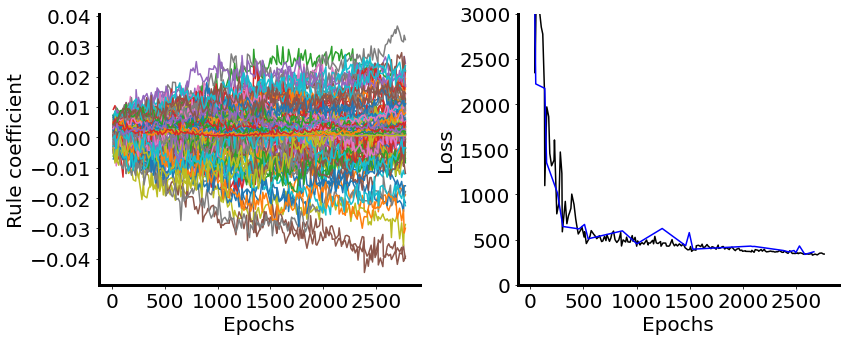

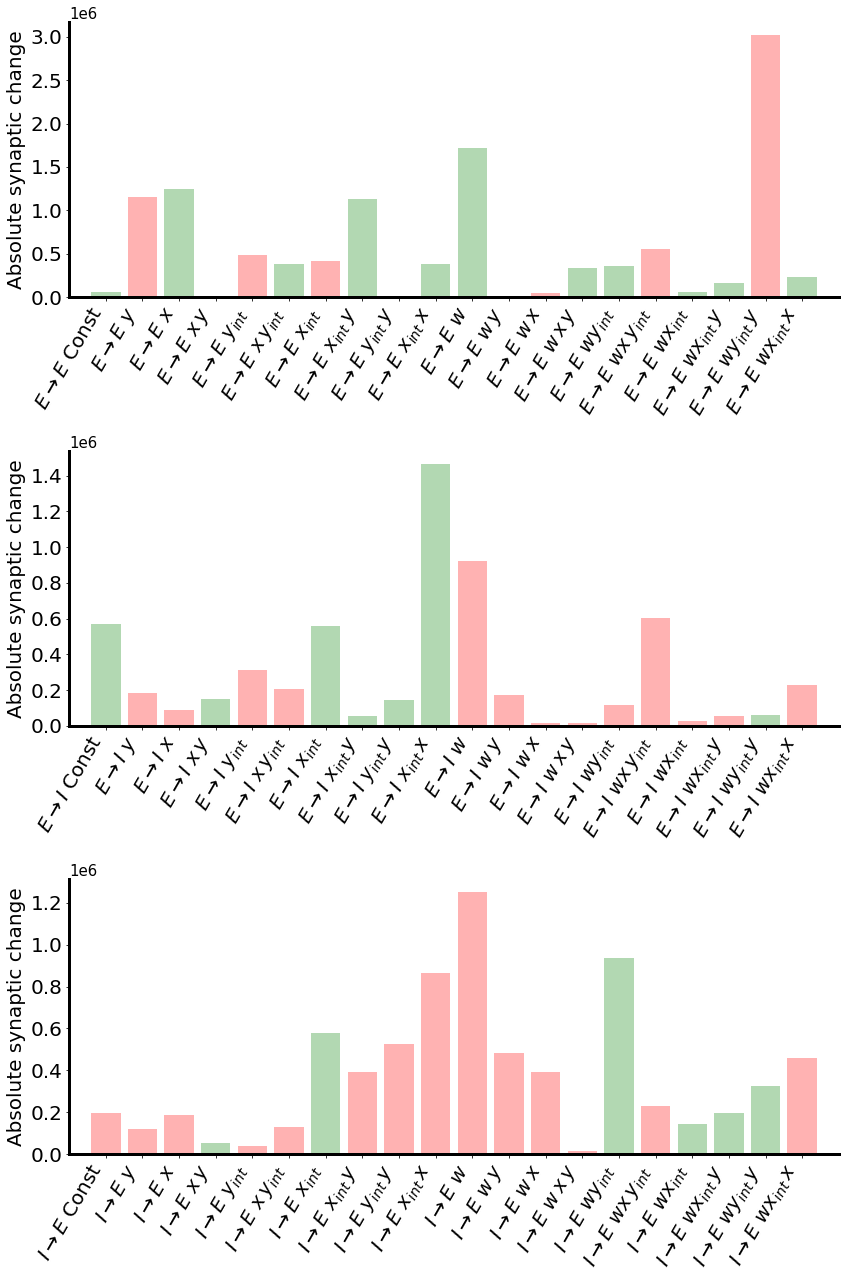

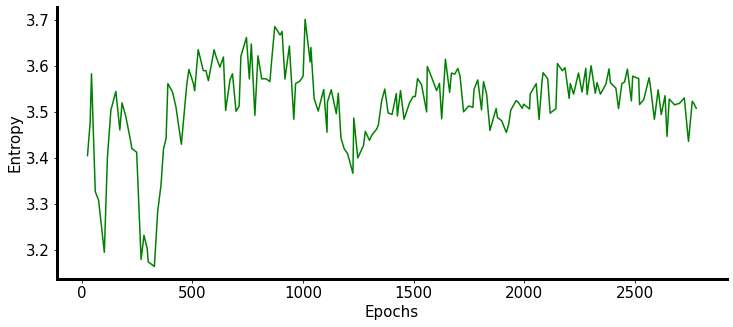

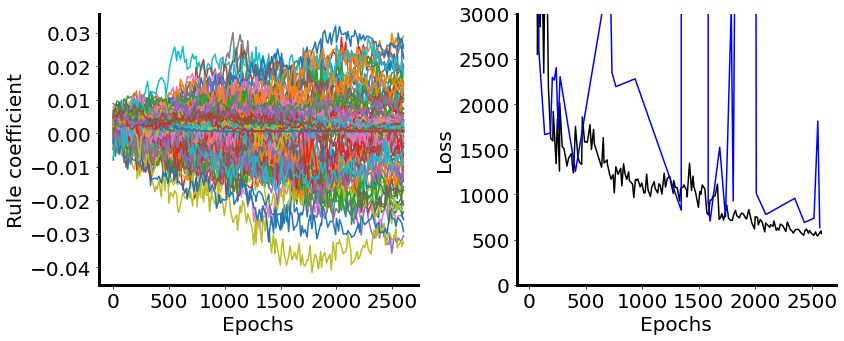

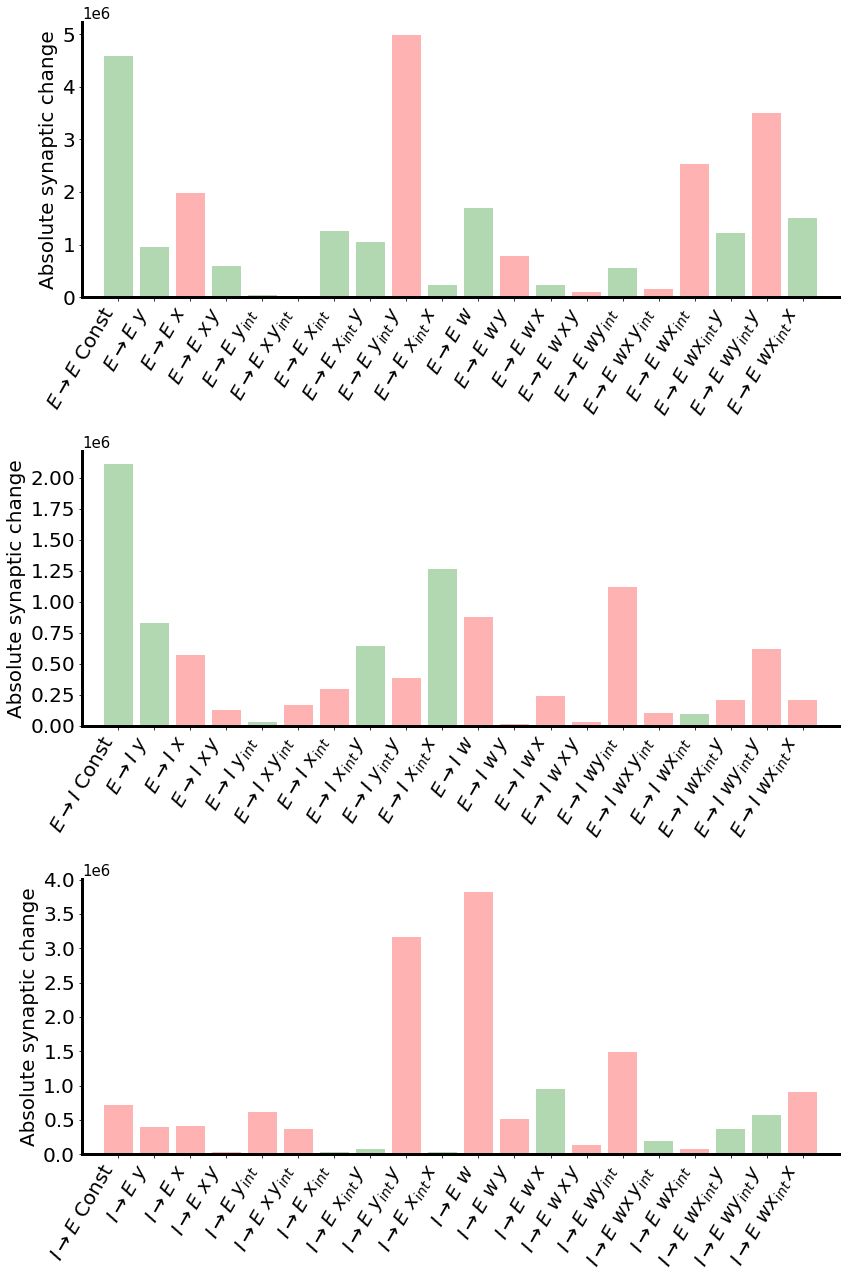

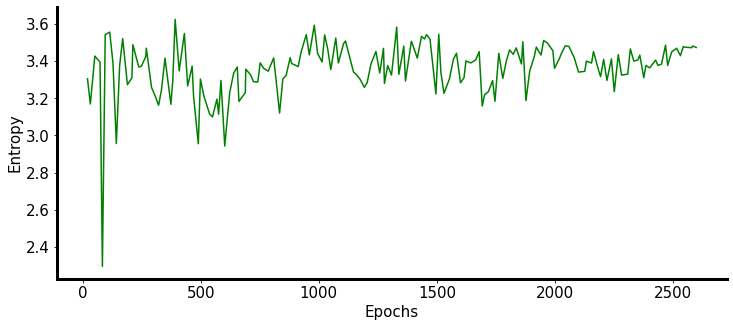

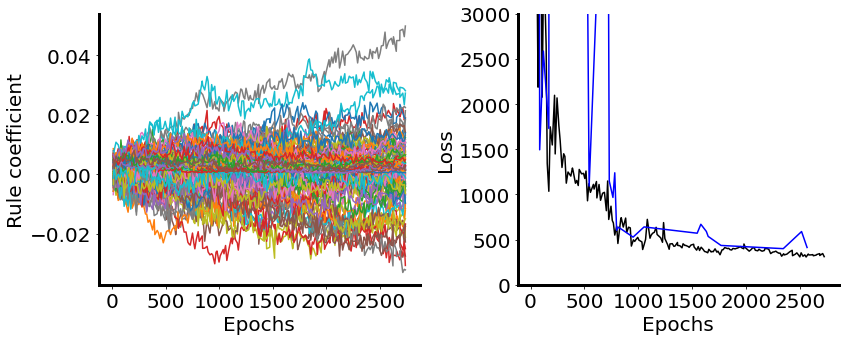

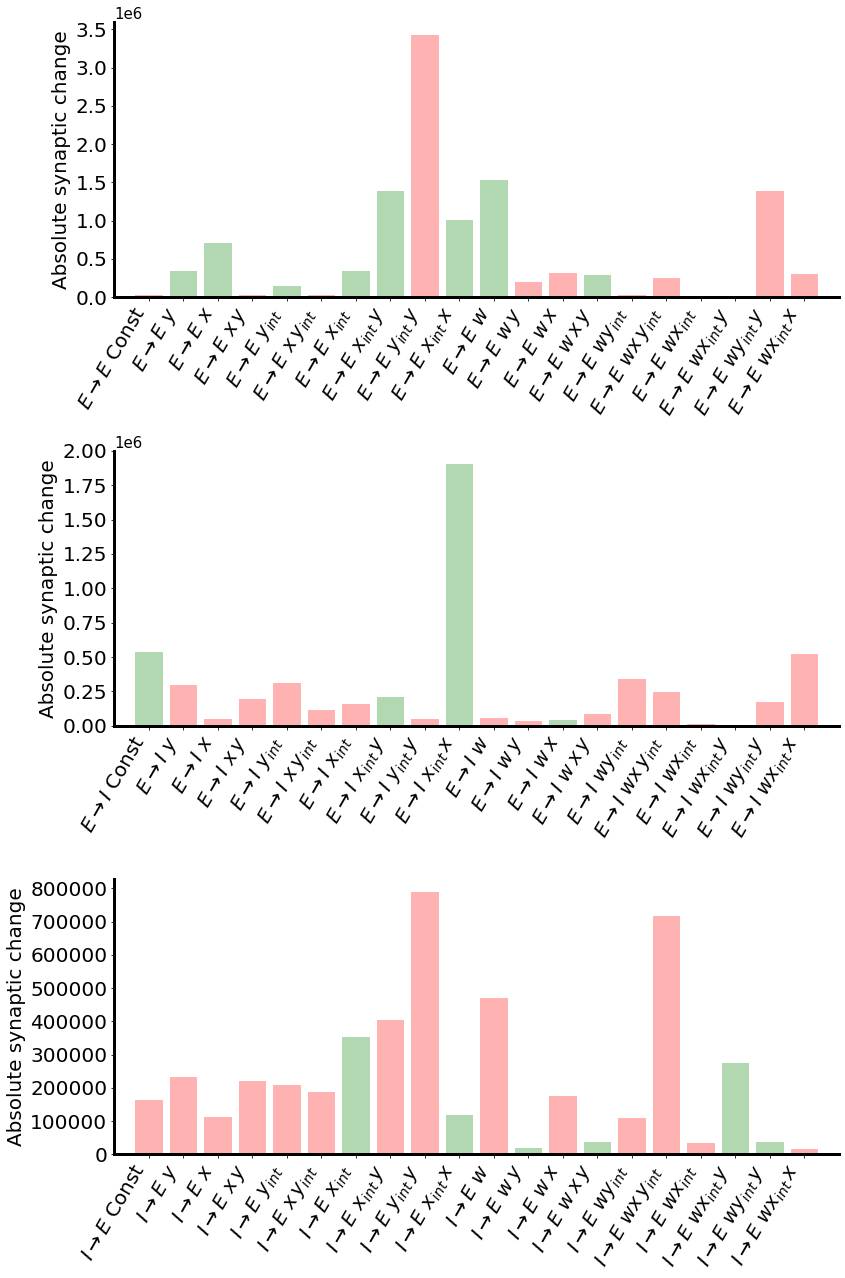

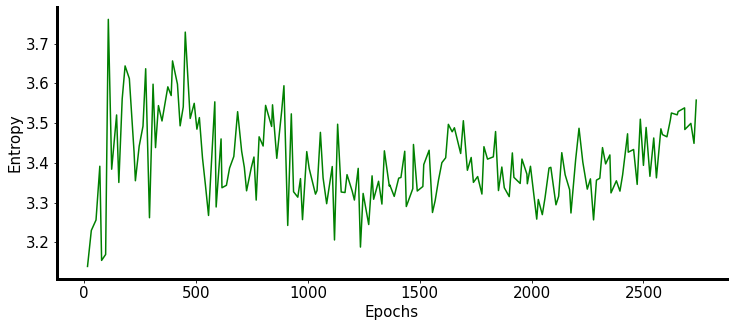

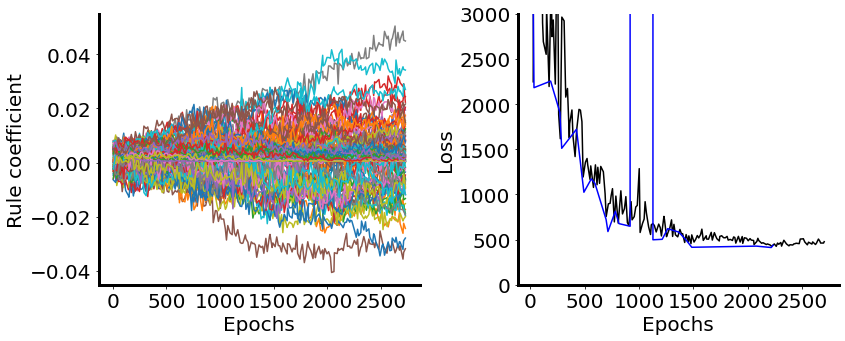

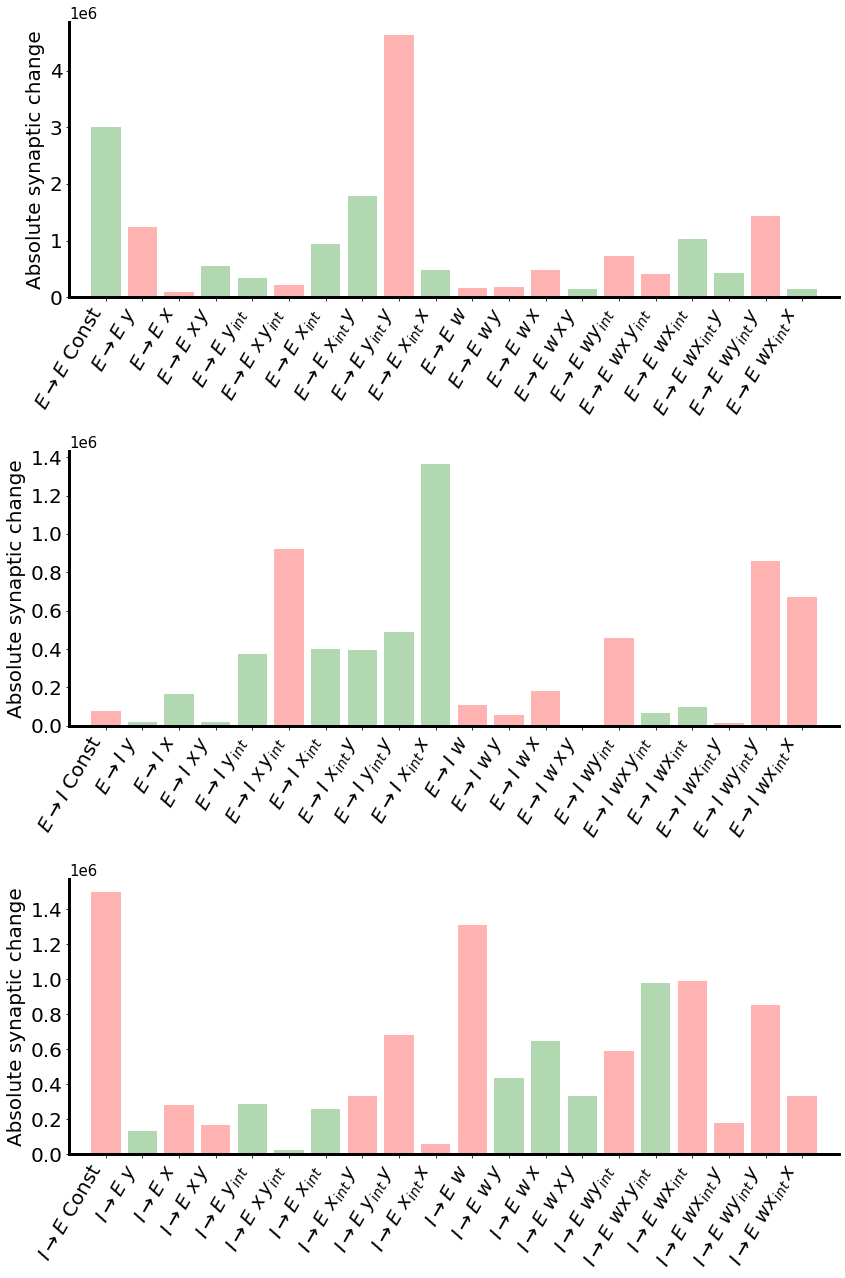

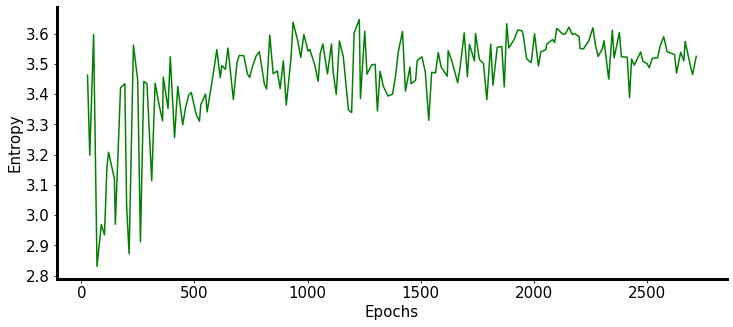

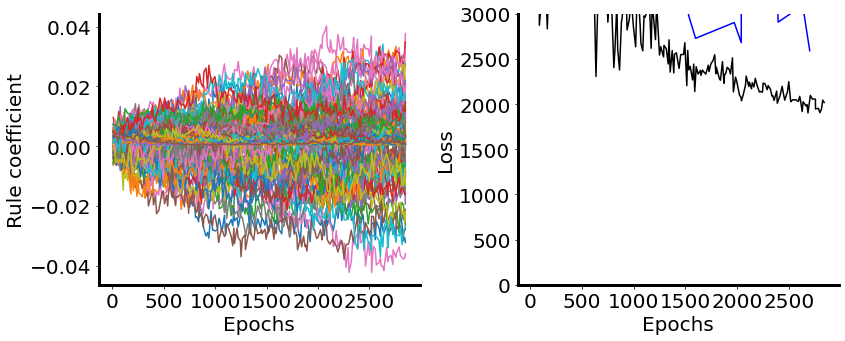

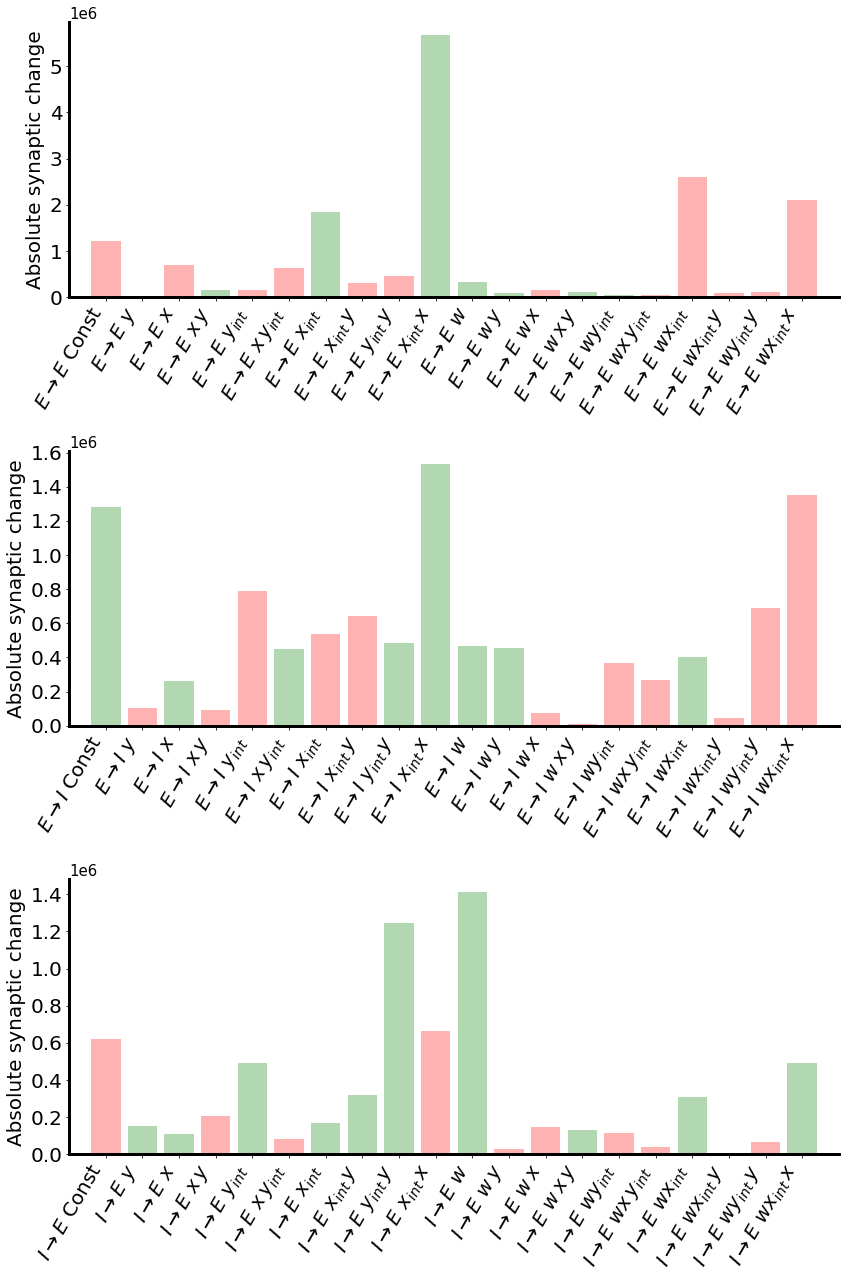

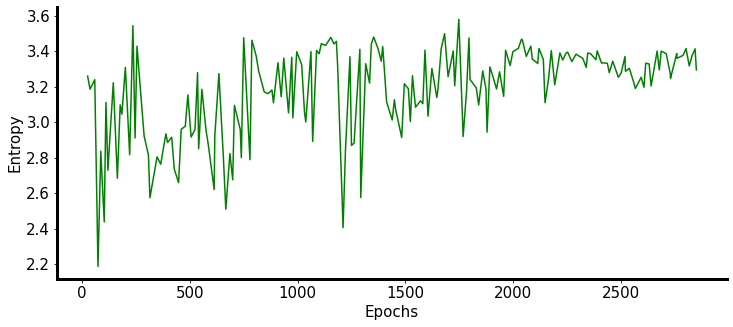

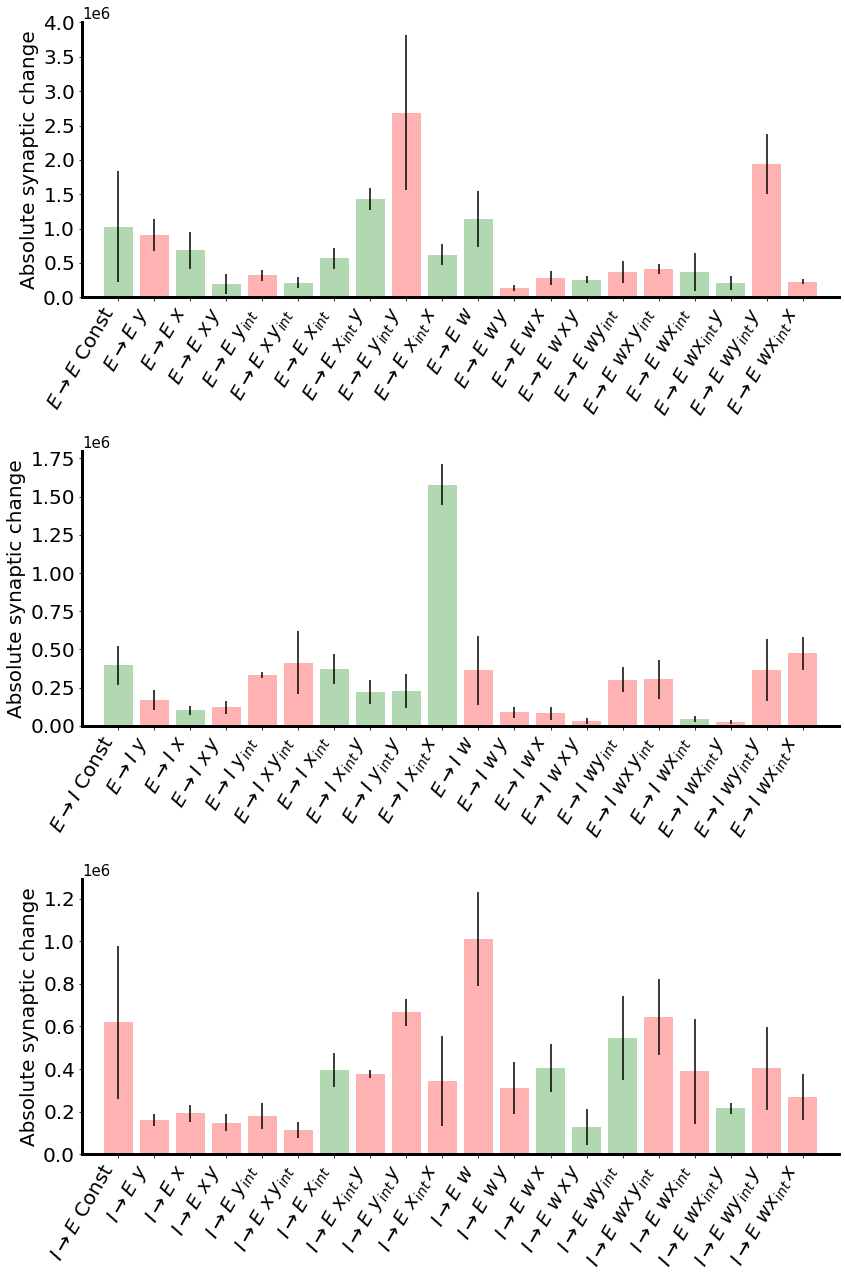

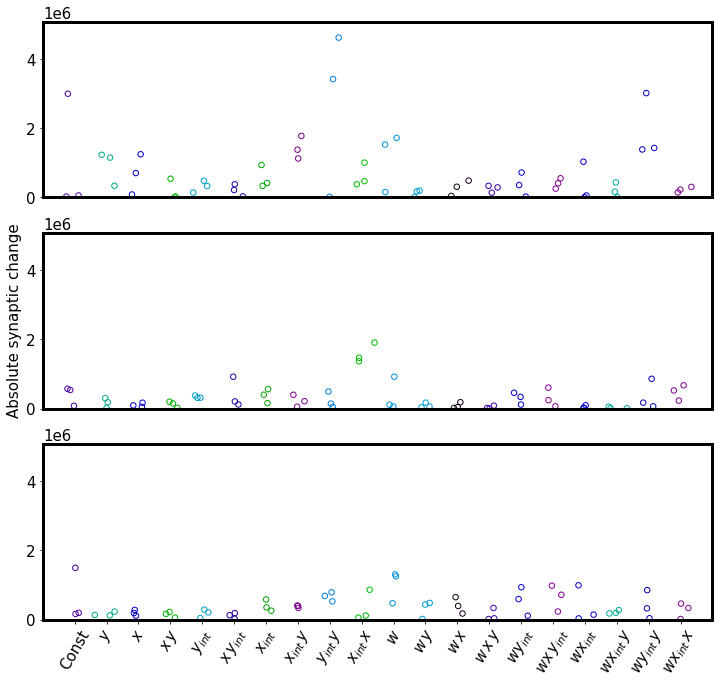

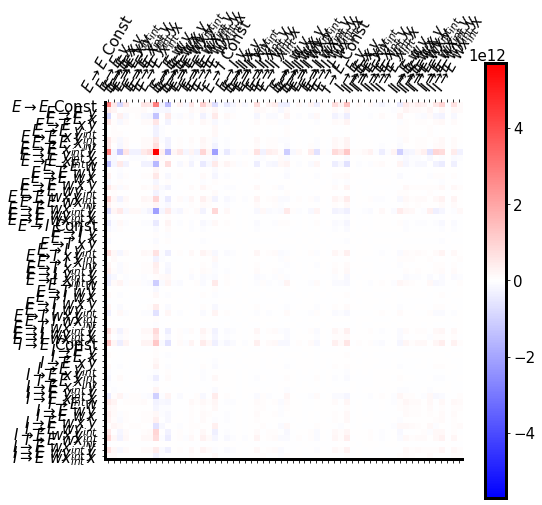

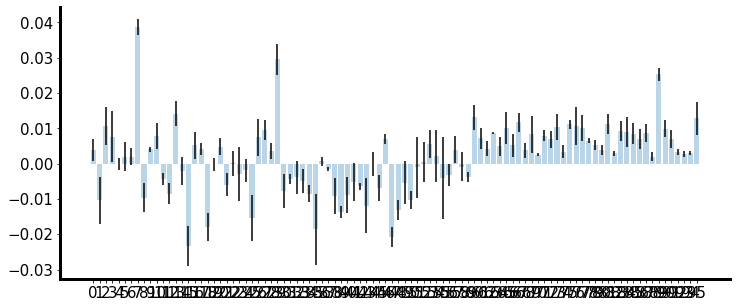

In [7]:
all_files = [
    'decoder_ei_rollback_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8000_2023-09-06_00:24:17.357308',
    'decoder_ei_rollback_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8001_2023-09-06_00:24:46.620527',
    'decoder_ei_rollback_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8002_2023-09-06_00:25:25.221655',
    'decoder_ei_rollback_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8003_2023-09-06_00:26:10.584744',
    'decoder_ei_rollback_10_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_8004_2023-09-06_00:27:03.961824',
]

plot_all_opt_runs(all_files, 60, 36, 10, l_thresh=500, n_categories=3, name='all_unperturbed')

In [77]:
def loss_scatters(file_name, n_plasticity_coefs, n_time_constants, batch_size, n_networks=30, n_categories=1):
    figure_path = f'./figures/{file_name}'
    Path(figure_path).mkdir(parents=True, exist_ok=True)
    
    scale = 2
    gs = gridspec.GridSpec(8 * n_categories, 1, bottom=0.5, hspace=0.4)
    fig = plt.figure(figsize=(6 * scale, 6 * n_categories * scale), tight_layout=True)
    axs = []
    for i in range(n_categories):
        axs.append([fig.add_subplot(gs[i * 8: i * 8 + 2]), fig.add_subplot(gs[i * 8 + 2:i * 8 + 5])])
        
    gs_2 = gridspec.GridSpec(5 * n_categories, 1, bottom=0.5,)
    fig_2 = plt.figure(figsize=(6 * scale, 3 * n_categories * scale), tight_layout=True)
    axs_2 = []
    for i in range(n_categories):
        axs_2.append([fig_2.add_subplot(gs_2[i * 5: i * 5 + 2]), fig_2.add_subplot(gs_2[i * 5 + 2:i * 5 + 5])])
        
    cutoff = 100
    rules_per_category = int(n_plasticity_coefs / n_categories)
    
    for ax in [axs, axs_2]:
        for i in range(len(axs)):
            ax[i][1].set_ylabel('Loss')
            ax[i][0].set_xticks([])
            ax[i][0].set_xticklabels([])
            if i == 0:
                ax[i][1].set_xticks(np.arange(rules_per_category + 1))
                ax[i][1].set_xticklabels(np.concatenate([['None'], rule_names[i*rules_per_category:(i+1)*rules_per_category]]), rotation=60, ha='right')
            else:
                ax[i][1].set_xticks(np.arange(rules_per_category))
                ax[i][1].set_xticklabels(rule_names[i*rules_per_category:(i+1)*rules_per_category], rotation=60, ha='right')

            ax[i][0].set_yscale('log')
            ax[i][0].set_ylim(50, 1e9)
            ax[i][1].set_ylim(0, cutoff * 1.1)
            ax[i][0].set_xlim(-1, n_plasticity_coefs/n_categories + 1)
            ax[i][1].set_xlim(-1, n_plasticity_coefs/n_categories + 1)

            ax[i][0].spines['bottom'].set_visible(False)
            ax[i][0].spines['right'].set_visible(False)
            ax[i][1].spines['top'].set_visible(False)
            ax[i][1].spines['right'].set_visible(False)
        
    
    train_data_path = f'./sims_out/{file_name}/train_data.csv'
    df_train = read_csv(train_data_path, read_header=False)

    syn_effect_start = 2 + batch_size + n_plasticity_coefs + n_time_constants
    syn_effect_end = 2 + batch_size + n_plasticity_coefs + n_time_constants + n_plasticity_coefs
    plasticity_coefs_start = 2 + batch_size
    plasticity_coefs_end = 2 + batch_size + n_plasticity_coefs + n_time_constants

    losses = df_train[df_train.columns[1]]
    
    all_losses_for_dropouts = np.array([losses[i:i + n_networks] for i in range(0, (n_plasticity_coefs + 1) * n_networks, n_networks)])
    mean_losses_for_dropouts = np.array([np.mean(ls) for ls in all_losses_for_dropouts])
    std_losses_for_dropouts = np.array([np.std(ls) for ls in all_losses_for_dropouts])
    cis_for_dropouts = 1.26 * (std_losses_for_dropouts / np.sqrt(n_networks))
    
    sig_diff = np.where(mean_losses_for_dropouts - cis_for_dropouts > mean_losses_for_dropouts[0] + cis_for_dropouts[0], True, False)
    
    means_under_cutoff = mean_losses_for_dropouts < cutoff

    for i in range(0, (n_plasticity_coefs + 1) * n_networks, n_networks):
        category_idx = int(i/n_categories)
        idx = int(i/n_networks)
        if idx < n_networks:
            category_idx = 0
        else:
            category_idx = int((idx - 1)/rules_per_category)
        losses_for_dropout = losses[i:i + n_networks]
        
        color = 'red' if sig_diff[idx] else 'black'
        
        
        under_cutoff = losses_for_dropout < cutoff
        offset = int(category_idx > 0)
        axs[category_idx][0].scatter((np.ones(n_networks) * (idx - category_idx * rules_per_category - offset) + np.random.normal(size=n_networks, scale=0.15))[~under_cutoff],
                    losses_for_dropout[~under_cutoff], marker='o', facecolor='none', edgecolor=color)
        axs[category_idx][1].scatter((np.ones(n_networks) * (idx - category_idx * rules_per_category - offset) + np.random.normal(size=n_networks, scale=0.15))[under_cutoff],
                    losses_for_dropout[under_cutoff], marker='o', facecolor='none', edgecolor=color)
    
    
        if not means_under_cutoff[idx]:
            axs_2[category_idx][0].errorbar([idx],
                        mean_losses_for_dropouts[idx],
                        yerr=cis_for_dropouts[idx], color=color, capsize=4, linestyle='')
            axs_2[category_idx][0].scatter([idx],
                        mean_losses_for_dropouts[idx], color=color)
        else:
            axs_2[category_idx][1].errorbar([idx], 
                        mean_losses_for_dropouts[idx],
                        yerr=cis_for_dropouts[idx], color=color, capsize=4, linestyle='')
            axs_2[category_idx][1].scatter([idx],
                        mean_losses_for_dropouts[idx], color=color)
    
    for i in range(n_categories):
        set_font_size(axs[i][0], 20)
        set_font_size(axs[i][1], 20)
    fig.tight_layout()
    fig.savefig(os.path.join(figure_path, 'rule_perturbation.png'))
    fig.savefig(os.path.join(figure_path, 'rule_perturbation.svg'))
        

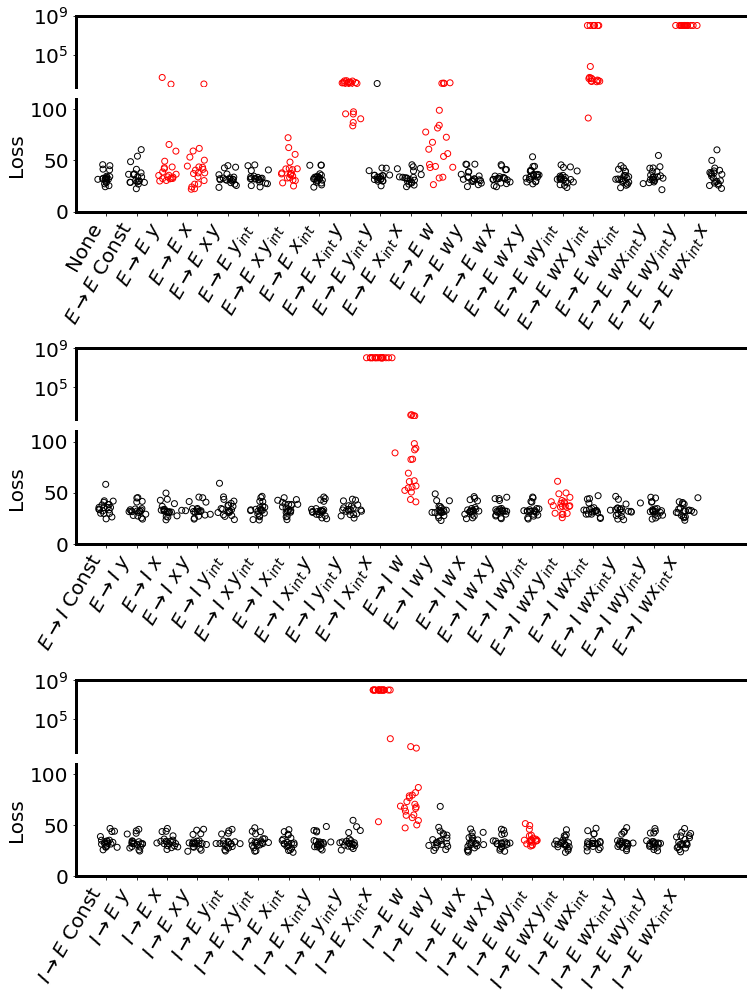

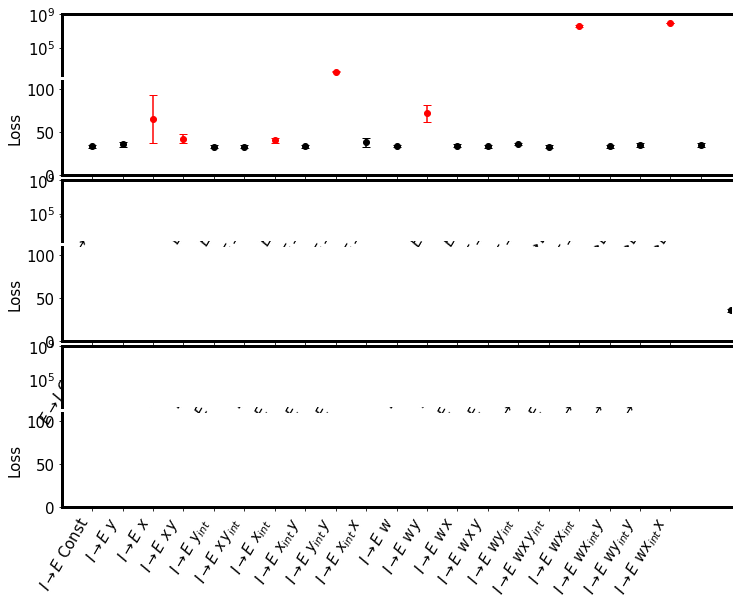

In [78]:
file_name = 'stress_test_ei_decoder_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-11-11_20:41:02.660282'
loss_scatters(file_name, 60, 36, 1, n_networks=20, n_categories=3)


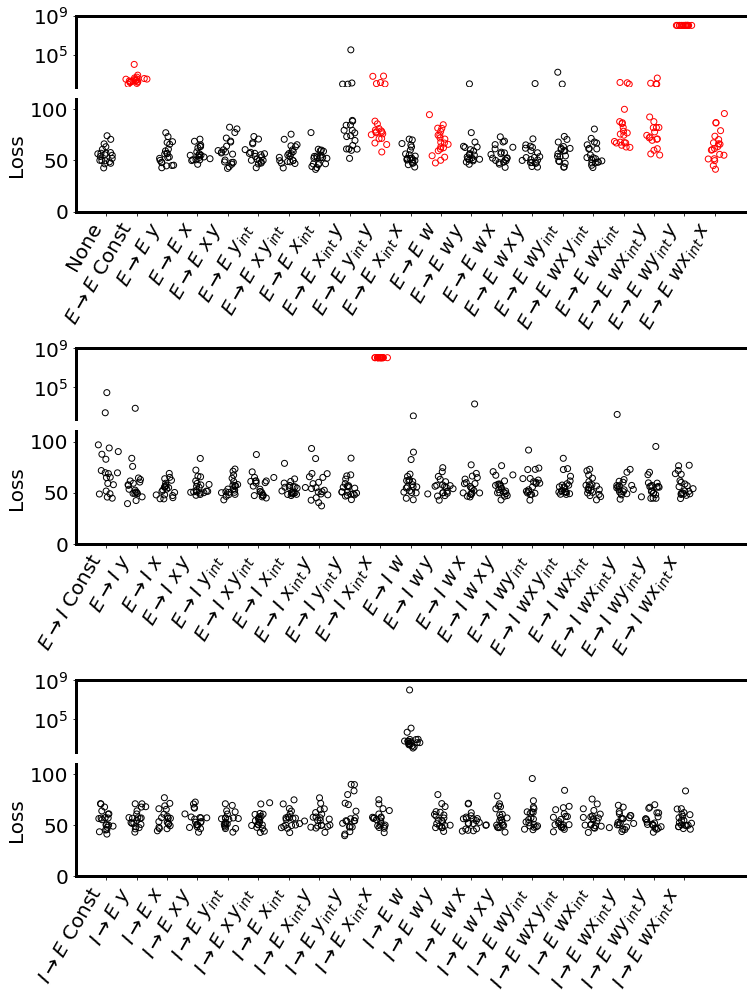

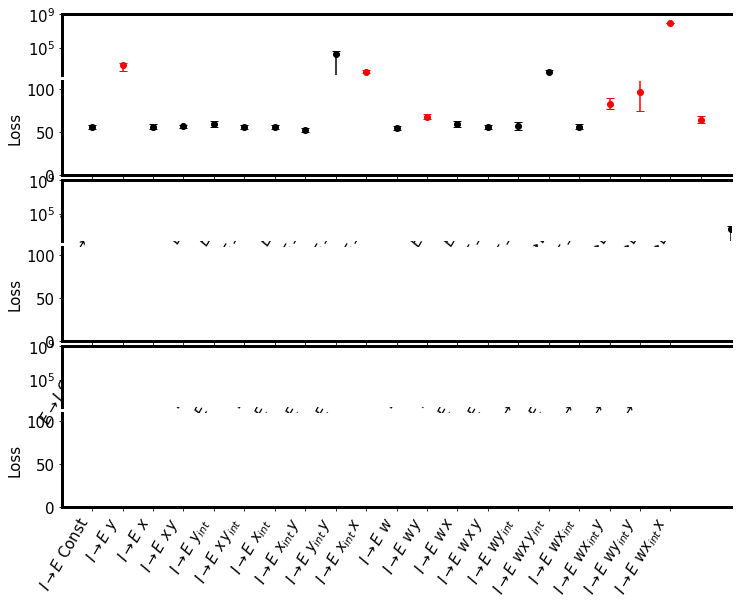

In [79]:
file_name = 'stress_test_ei_decoder_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-11-11_20:42:29.156532'
loss_scatters(file_name, 60, 36, 1, n_networks=20, n_categories=3)

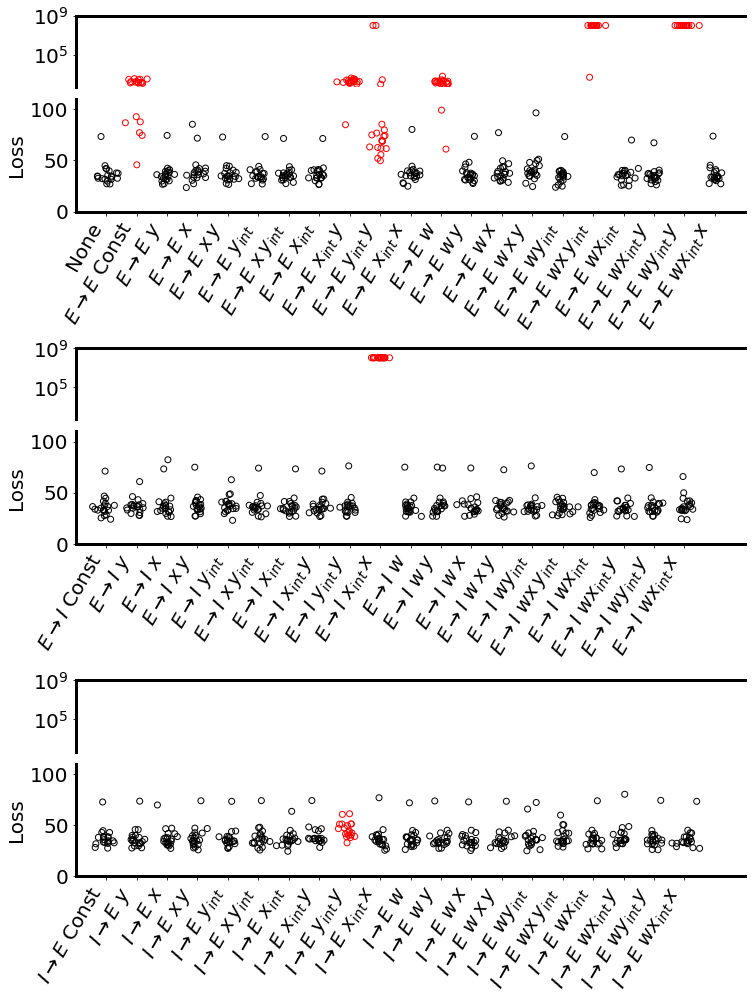

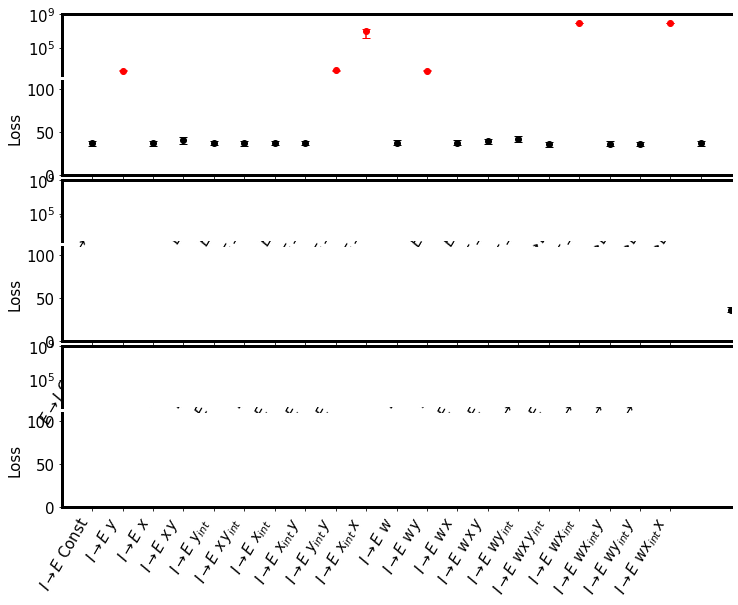

In [80]:
file_name = 'stress_test_ei_decoder_1_STD_EXPL_0.003_FIXED_True_L1_PENALTY_5e-07_5e-07_5e-07_ACT_PEN_1_CHANGEP_0.0_FRACI_0.75_SEED_500_2023-11-11_20:42:29.156566'
loss_scatters(file_name, 60, 36, 1, n_networks=20, n_categories=3)